In [1]:
import os
import pandas as pd
import numpy as np
    # Librerías para el procesado de imagen
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image
from collections import defaultdict
from PIL import Image
import imageio
from mlxtend.image import extract_face_landmarks
import itertools
    # Librerías para ML
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
path = '../input/'

In [3]:
df = pd.read_excel(path + 'CFD_2.0.3_Norming_Data_and_Codebook.xlsx', sheet_name='CFD 2.0.3 Norming Data')

In [4]:
df.head()

,Target,Race,Gender,Age,NumberofRaters,Female_prop,Male_prop,Asian_prop,Black_prop,Latino_prop,...,EyeShape,EyeSize,UpperHeadLength,MidfaceLength,ChinLength,ForeheadHeight,CheekboneHeight,CheekboneProminence,FaceRoundness,fWHR
0,AF-200,A,F,32.571429,28,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.404651,0.060924,0.414099,0.326797,0.130719,0.264706,0.388189,91.5,0.545752,1.921146
1,AF-201,A,F,23.666667,27,1.000000,0.000000,0.962963,0.000000,0.000000,...,0.329204,0.041892,0.414414,0.329279,0.144595,0.300901,0.383784,146.0,0.488288,1.901129
2,AF-202,A,F,24.448276,29,0.827586,0.172414,0.310345,0.068966,0.137931,...,0.357939,0.051586,0.411080,0.310317,0.173424,0.298475,0.397029,58.0,0.481333,1.888249
3,AF-203,A,F,22.758621,29,1.000000,0.000000,0.758621,0.000000,0.068966,...,0.443200,0.063913,0.354407,0.343793,0.169820,0.272266,0.421089,87.5,0.500231,1.863719
4,AF-204,A,F,30.137931,29,1.000000,0.000000,0.827586,0.000000,0.068966,...,0.432247,0.053435,0.438931,0.293045,0.180237,0.293893,0.371925,73.5,0.513571,1.935783


In [5]:
df_clean = df[['Target', 'Attractive']]
df_clean.head()

,Target,Attractive
0,AF-200,4.111111
1,AF-201,3.111111
2,AF-202,3.000000
3,AF-203,3.275862
4,AF-204,3.172414


In [6]:
print(df_clean.shape)

(597, 2)


In [7]:
for index, row in df.iterrows():
    if row['Target']=='BM':
        df.drop(index, inplace=True)

In [8]:
all_images = defaultdict(list)
for filename, rating in df_clean.values:
    all_images[filename].append(rating)

In [9]:
ratings = {}
for filename, rating in all_images.items():
    ratings[filename] = np.mean(rating)

In [10]:
value = []
path2 = path + 'CFD-Version-2.0.3-Norming-Data/Images/'
path3 = path + 'CFD-Version-2.0.3-Norming-Data/Images_resized/'
for filename in os.listdir(path2):
    img_path = path2 + filename
    img = image.load_img(img_path).convert('L')
    img.thumbnail((200,200), Image.ANTIALIAS)
    img.save(path3 + filename, "JPEG")
    value.append(ratings[filename[:6]])
print(len(value))

597


In [11]:
images_array = []
landmarks = []
for filename in os.listdir(path3):
    img = imageio.imread(path3 + filename)
    landmark = extract_face_landmarks(img)
    images_array.append(img)
    landmarks.append(landmark)

In [12]:
print(type(images_array))
print(len(images_array), len(images_array[0]), len(images_array[0][0]))

<class 'list'>
598 140 200


In [13]:
images_array = np.array(images_array)
landmarks = np.array(landmarks)
print(type(images_array),type(landmarks))
print(len(images_array), images_array[0].shape, landmarks.shape)
print('\nFirst 10 landmarks:\n', landmarks[0][:10])

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
598 (140, 200) (598, 68, 2)

First 10 landmarks:
 [[ 65  66]
 [ 66  75]
 [ 68  83]
 [ 70  91]
 [ 72  99]
 [ 77 107]
 [ 84 112]
 [ 91 118]
 [100 119]
 [109 118]]


Rating: 4.111111111


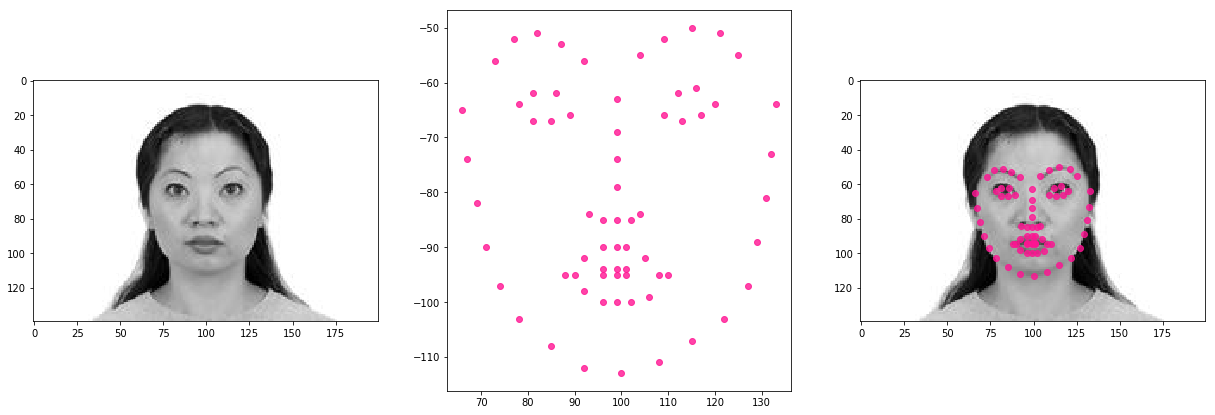

In [14]:
def plot_landmarks(img, landmarks, to_print=False, filename='example_landmarks.png'):
    fig = plt.figure(figsize=(21, 7))
    ax = fig.add_subplot(1, 3, 1)
    #img = np.reshape(img, (147,210))
    ax.imshow(img, cmap='gray')
    ax = fig.add_subplot(1, 3, 2)
    ax.scatter(landmarks[:, 0], -landmarks[:, 1], c='deeppink', alpha=0.8)
    ax = fig.add_subplot(1, 3, 3)
    img2 = img.copy()
    ax.imshow(img2, cmap='gray')
    ax.scatter(landmarks[:, 0], landmarks[:, 1], c='deeppink', alpha=0.8)
    if to_print: 
        fig.savefig('../images/' + filename)
    plt.show()
    
print('Rating: {}'.format(value[16]))
plot_landmarks(images_array[16], landmarks[16], to_print=True)

In [15]:
total_land = 68*2
landmarks_ = landmarks.reshape(598,total_land)

In [16]:
data_zipped = list(zip(images_array, value, landmarks_))
data = pd.DataFrame(data_zipped, columns=['Images','Rating', 'Landmarks'])
data = data.drop(447)
data.reset_index(inplace=True, drop=True)
data.head()

,Images,Rating,Landmarks
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3.821429,"[65, 66, 66, 75, 68, 83, 70, 91, 72, 99, 77, 1..."
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",2.777778,"[64, 66, 65, 75, 66, 84, 68, 92, 71, 101, 75, ..."
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3.280000,"[69, 64, 69, 73, 71, 81, 73, 89, 75, 97, 79, 1..."
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3.857143,"[66, 65, 67, 74, 68, 83, 70, 91, 73, 100, 78, ..."
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3.000000,"[66, 66, 67, 74, 68, 82, 70, 90, 72, 97, 77, 1..."


In [17]:
df_landmarks = data['Landmarks']
df_landmarks = pd.concat([df_landmarks.apply(pd.Series), df_landmarks], axis=1).drop(['Landmarks'], axis=1)
df_landmarks.columns = ["x_%d"%i if i%2==0 or i==0 else "y_%d"%(i-1) for i in range(136)]
df_landmarks.head()

,x_0,y_0,x_2,y_2,x_4,y_4,x_6,y_6,x_8,y_8,...,x_126,y_126,x_128,y_128,x_130,y_130,x_132,y_132,x_134,y_134
0,65,66,66,75,68,83,70,91,72,99,...,103,96,110,97,103,96,100,97,96,96
1,64,66,65,75,66,84,68,92,71,101,...,103,95,110,96,103,95,99,95,96,95
2,69,64,69,73,71,81,73,89,75,97,...,104,97,113,96,104,96,100,97,96,96
3,66,65,67,74,68,83,70,91,73,100,...,104,95,111,95,104,95,102,95,99,95
4,66,66,67,74,68,82,70,90,72,97,...,104,92,110,93,104,92,101,93,98,92


In [18]:
score = data['Rating']
def create_bins(data):
    bins = (0, 1, 2, 3, 4, 5, 6)
    labels = (0, 1, 2, 3, 4, 5)
    groups = pd.cut(score, bins=bins, labels=labels)
    return groups

In [19]:
data['Ratings'] = create_bins(data)
data = data.drop(['Rating', 'Landmarks'], axis=1)

In [20]:
print(len(data))
data.head()

596


,Images,Ratings
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",2
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",3
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",2


In [21]:
def save_csv(name, filename):
    name.to_csv('../output/' + filename, index=False)

In [22]:
save_csv(df_landmarks, filename='landmarks_cleaned.csv')

In [23]:
save_csv(data, filename='data_cleaned.csv')

# MODELAJE

In [24]:
img_cols = 200
img_rows = 140

In [25]:
def reshape(e):
    return e[0].reshape(e[0].shape[0]*e[0].shape[1])/255
df_img = pd.DataFrame(data['Images'].iloc[0:5976]).apply(reshape,axis=1, result_type="expand")
df_img.head()

,0,1,2,3,4,5,6,7,8,9,...,27990,27991,27992,27993,27994,27995,27996,27997,27998,27999
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,0.996078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996078
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,0.992157,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
num_img = df_img.values.shape[0]
print(num_img)

596


In [27]:
df_img = df_img.values.reshape((img_rows, img_cols, num_img))

In [28]:
data['Ratings'].value_counts()

2    240
3    238
4     92
1     19
5      7
0      0
Name: Ratings, dtype: int64

In [29]:
X = df_img.swapaxes(2,0)
y = np.array(data['Ratings'].values)
print(X.shape, y.shape)
print(X.dtype, y.dtype)

(596, 200, 140) (596,)
float64 int64


In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
num_classes = 6

if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [32]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (476, 140, 200, 1)
476 train samples
120 test samples


In [33]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Y_train shape:', y_train.shape)

Y_train shape: (476, 6)


In [34]:
model = Sequential()
model.add(Conv2D(120, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(200, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(476, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
batch_size = 20
epochs = 10

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 476 samples, validate on 120 samples
Epoch 1/10
